In [3]:
# Silence all warnings
import warnings

import contextily as cx
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
import planetary_computer
import pyproj
import pystac_client
import seaborn as sns
import xarray as xr
from dask.distributed import Client
from dask_ml.cluster import KMeans
from dask_ml.linear_model import LogisticRegression
from IPython.display import Image
from matplotlib.patches import Rectangle
from skimage.filters import threshold_otsu
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

## Data Preparation

As in previous weeks, we'll start by importing our data from Microsoft's Planetary Computer. We're searching for the Landsat 8, Level 2 collection, filtered for the summer of 2017 over a lake in Nevada, USA.

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

bbox = [-118.89, 38.54, -118.57, 38.84]  # Region over a lake in Nevada, USA
datetime = "2017-06-01/2017-09-30"  # Summer months of 2017
collection = "landsat-c2-l2"
platform = "landsat-8"
cloudy_less_than = 1  # percent

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}, "platform": {"in": [platform]}},
)
items = search.item_collection()
print(f"Returned {len(items)} Items:")
[[i, item.id] for i, item in enumerate(items)]

Returned 3 Items:


[[0, 'LC08_L2SP_042033_20170718_02_T1'],
 [1, 'LC08_L2SP_042033_20170702_02_T1'],
 [2, 'LC08_L2SP_042033_20170616_02_T1']]

In [5]:
item = items[1]  # select one of the results

Notice how cloud cover here is minimal! This makes our lives easy.

In [6]:
Image(url=item.assets["rendered_preview"].href)

In the data processing steps that follow, we're mostly just copy and pasting directly from the tutorial. We'll get more analytical when it comes time to actually run our clustering model.

In [7]:
assets = []
for _, asset in item.assets.items():
    try:
        assets.append(asset.extra_fields["eo:bands"][0])
    except:
        pass

cols_ordered = [
    "common_name",
    "description",
    "name",
    "center_wavelength",
    "full_width_half_max",
]
bands = pd.DataFrame.from_dict(assets)[cols_ordered]
bands

,common_name,description,name,center_wavelength,full_width_half_max
0,red,Visible red,OLI_B4,0.65,0.04
1,blue,Visible blue,OLI_B2,0.48,0.06
2,green,Visible green,OLI_B3,0.56,0.06
3,nir08,Near infrared,OLI_B5,0.87,0.03
4,lwir11,Long-wave infrared,TIRS_B10,10.90,0.59
5,swir16,Short-wave infrared,OLI_B6,1.61,0.09
6,swir22,Short-wave infrared,OLI_B7,2.20,0.19
7,coastal,Coastal/Aerosol,OLI_B1,0.44,0.02


In [8]:
ds_2017 = odc.stac.stac_load(
    [item],
    bands=bands.common_name.values,
    bbox=bbox,
    chunks={},  # <-- use Dask
).isel(time=0)

Here, we can view our data array in `xarray` format. This is a good opportunity to mentally connect the concept of a data array to an EO data cube. We can clearly see our four dimensions of x, y, bands, and time.

In [9]:
epsg = item.properties["proj:code"]
ds_2017.attrs["crs"] = f"epsg:{epsg}"

da_2017 = ds_2017.to_array(dim="band")
da_2017

<xarray.DataArray (band: 8, y: 1128, x: 950)> Size: 17MB
dask.array<stack, shape=(8, 1128, 950), dtype=uint16, chunksize=(1, 1128, 950), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
  * y            (y) float64 9kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
  * x            (x) float64 8kB 3.353e+05 3.353e+05 ... 3.637e+05 3.638e+05
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
Attributes:
    crs:      epsg:EPSG:32611

Now comes the part that needs some explanation. We're going to flatten our array to create vectors of the pixels of each image. This is a really important concept in remote sensing and deep learning--we'll about it a lot in the second half of the semester. Here's an expllanation from the Landsat ML Cookbook tutorial:

> The shape of our data is currently `n_bands`, `n_y`, `n_x`. In order for `dask-ml` / `scikit-learn` to consume our data, we'll need to reshape our image stacks into `n_samples`, `n_features`, where `n_features` is the number of wavelength-bands and `n_samples` is the total number of pixels in each wavelength-band image. Essentially, we'll be creating a vector of pixels out of each image, where each pixel has multiple features (bands), but the ordering of the pixels is no longer relevant to the computation.
> 
> By using xarray methods to flatten the data, we can keep track of the coordinate labels 'x' and 'y' along the way. This means that we have the ability to reshape back to our original array at any time with no information loss!

Here's a nice explanation from [a Medium article by Hause Lin](https://medium.com/data-science/reshaping-numpy-arrays-in-python-a-step-by-step-pictorial-tutorial-aed5f471cf0b):

![Python numpy reshape and stack cheatsheet](https://miro.medium.com/1%2AlFZzE9PgKTRR8jlFI4EUtw.png)

Now we have eight vectors of pixels--one for each band!

In [10]:
flattened_xda_2017 = da_2017.stack(z=("x", "y"))  # flatten each band
flattened_t_xda_2017 = flattened_xda_2017.transpose("z", "band")
flattened_t_xda_2017

<xarray.DataArray (z: 1071600, band: 8)> Size: 17MB
dask.array<transpose, shape=(1071600, 8), dtype=uint16, chunksize=(1071600, 1), chunktype=numpy.ndarray>
Coordinates:
  * z            (z) object 9MB MultiIndex
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
  * x            (z) float64 9MB 3.353e+05 3.353e+05 ... 3.638e+05 3.638e+05
  * y            (z) float64 9MB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

Note that we're NOT standardizing the data yet. We'll do that after we split our training data to avoid data leakage. For k-means clustering, we'll standardize the entire dataset, but for the supervised linear classifier, we need to be more careful about when normalization is applied.

## K-Means Clustering

In [ ]:
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.2.0.2:39291/status,
Dashboard: http://10.2.0.2:39291/status,Workers: 1
Total threads: 16,Total memory: 54.73 GiB
Status: running,Using processes: False
Comm: inproc://10.2.0.2/405977/1,Workers: 0
Dashboard: http://10.2.0.2:39291/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://10.2.0.2/405977/4,Total threads: 16
Dashboard: http://10.2.0.2:42297/status,Memory: 54.73 GiB
Nanny: None,


2026-02-04 12:04:31,565 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('transpose-66871339478595ec0a70602ed66317f6', 0, 2) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: <Task ('transpose-66871339478595ec0a70602ed66317f6', 0, 2) transpose(..., ...)>
new run_spec: Alias(('transpose-66871339478595ec0a70602ed66317f6', 0, 2)->('getitem-green-reshape-stack-transpose-66871339478595ec0a70602ed66317f6', 0, 2))
old dependencies: {('reshape-99014046d7e4a96b5f12d5939c8d64c2', 2, 0)}
new dependencies: frozenset({('getitem-green-reshape-stack-transpose-66871339478595ec0a70602ed66317f6', 0, 2)})

2026-02-04 1

For k-means clustering (unsupervised learning), we standardize the entire dataset. We're applying this because k-means is calculated based on Euclidian distance, and therefore sensitive to scale. If one feature has a much larger range of values than another, it can dominate the distance calculation and skew the results. Standardizing the data ensures that each feature contributes equally to the distance calculations, leading to more meaningful clustering results.

In [12]:
with xr.set_options(keep_attrs=True):
    rescaled_xda_2017 = (
        flattened_t_xda_2017 - flattened_t_xda_2017.mean()
    ) / flattened_t_xda_2017.std()
rescaled_xda_2017

<xarray.DataArray (z: 1071600, band: 8)> Size: 69MB
dask.array<truediv, shape=(1071600, 8), dtype=float64, chunksize=(1071600, 1), chunktype=numpy.ndarray>
Coordinates:
  * z            (z) object 9MB MultiIndex
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
  * x            (z) float64 9MB 3.353e+05 3.353e+05 ... 3.638e+05 3.638e+05
  * y            (z) float64 9MB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

 Note here that we're loading all eight bands into our k-means clusters! No feature selection.

In [13]:
X_2017 = client.persist(rescaled_xda_2017)
X_2017.shape

(1071600, 8)

Now it's time for our clustering! The original tutorial uses spectral clustering, which is a slightly more sophisticated approach to k-means. We're using regular old k-means here just because the spectral clustering module was behaving weirdly in Dask. The concepts are the same, though.

The idea is simply to group pixels bsaed on similarity across all wavelength bands, based on Euclidian distance in multi-dimensional space. Here, we're using four clusters, per the tutorial, although this could be adjusted. This is _unsupervised_ clustering, meaning we don't provide any labels or guidance to the model about what the clusters should represent. The model simply identifies patterns in the data and groups similar pixels together. 

Lastly, I want to be clear that we're using k-means here because it's reasonably easy to understand and implement. In practice, more advanced clustering algorithms (like spectral clustering, hierarchical clustering, or DBSCAN) may yield better results depending on the specific characteristics of the dataset and the goals of the analysis. But k-means is what's available in Dask, so... it's what we're using.

In [14]:
kmeans = KMeans(n_clusters=4, random_state=0, max_iter=100)
kmeans.fit(X_2017)
labels = kmeans.labels_.compute()

template_2017 = flattened_t_xda_2017[:, 0]
output_array = template_2017.copy(data=labels)
output_array

<xarray.DataArray (z: 1071600)> Size: 4MB
array([1, 1, 1, ..., 0, 0, 0], shape=(1071600,), dtype=int32)
Coordinates:
  * z            (z) object 9MB MultiIndex
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
    band         <U3 12B 'red'
  * x            (z) float64 9MB 3.353e+05 3.353e+05 ... 3.638e+05 3.638e+05
  * y            (z) float64 9MB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

Per the tutorial:
> Once the computation is done, we can use the coordinates of our input array to restack our output array back into an image. Again, one of the main benefits of using `xarray` for this stacking and unstacking is that it keeps track of the coordinate information for us.

In [15]:
unstacked_2017 = output_array.unstack()
unstacked_2017

<xarray.DataArray (x: 950, y: 1128)> Size: 4MB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], shape=(950, 1128), dtype=int32)
Coordinates:
  * x            (x) float64 8kB 3.353e+05 3.353e+05 ... 3.637e+05 3.638e+05
  * y            (y) float64 9kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
    band         <U3 12B 'red'
Attributes:
    crs:      epsg:EPSG:32611

And now the moment of truth, mapping the clusters:

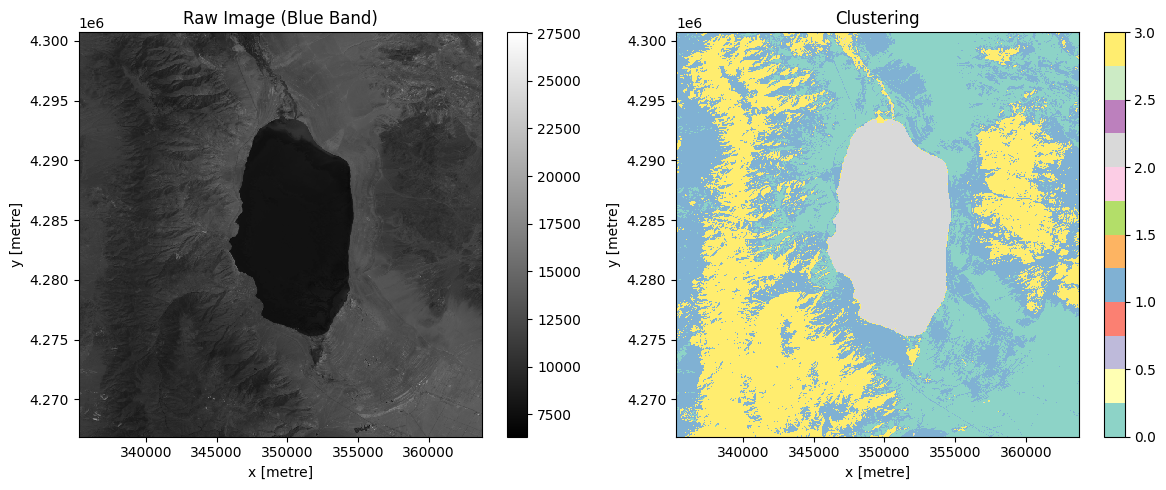

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot raw
da_2017.sel(band="blue").plot(ax=ax1, cmap="gray")
ax1.set_title("Raw Image (Blue Band)")

# Plot clustering - transpose if needed
unstacked_2017.T.plot(ax=ax2, cmap="Set3", vmin=0, vmax=3)  # Add .T to transpose
ax2.set_title("Clustering")

plt.tight_layout()
plt.show()

As you can see, the clustering results correspond quite well to the water/non-water. It's hard to tell from one band alone whether they correspond concretely to different land cover classes, but it's clear that the model is picking up on some meaningful patterns in the data.

## Supervised Classification with Linear Model

While k-means clustering is useful for unsupervised learning, we can potentially achieve better results with a supervised classifier. We'll train a logistic regression model using labeled samples of water and non-water areas.

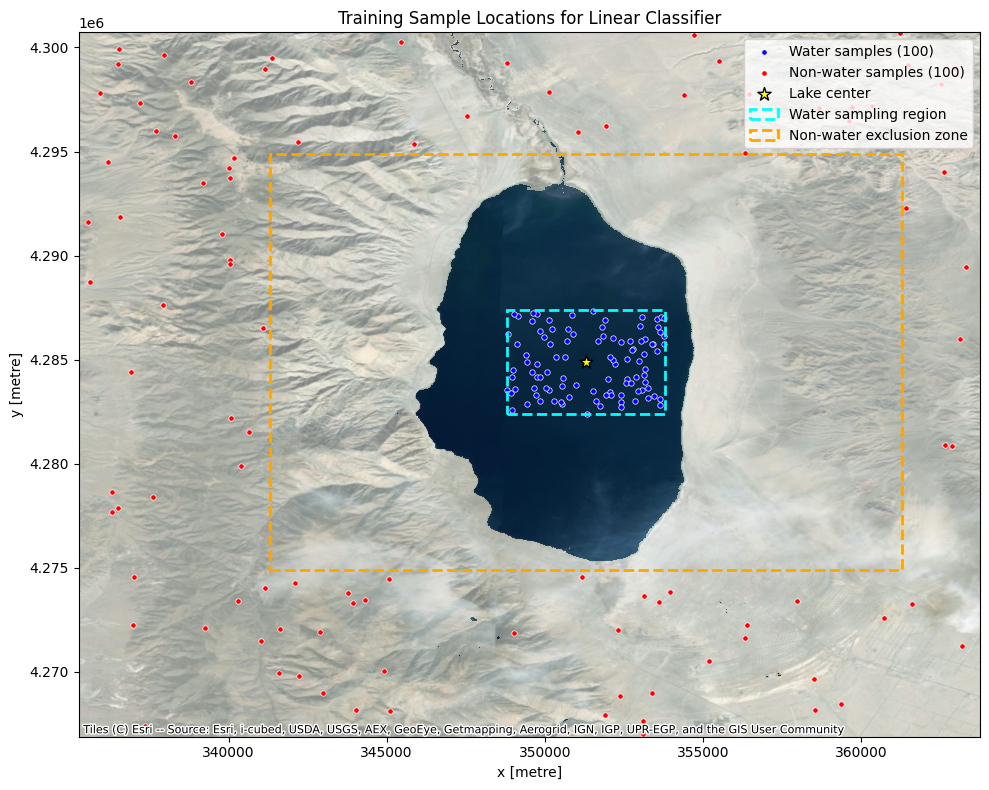

In [17]:
lon_lake_center = -118.71
lat_lake_center = 38.7

# Fix the CRS string - remove double prefix
crs_string = str(ds_2017.crs).replace("epsg:EPSG:", "EPSG:")
proj = pyproj.Proj(crs_string)
lake_center_x, lake_center_y = proj(lon_lake_center, lat_lake_center)

fig, ax = plt.subplots(figsize=(10, 8))

# Define the sampling regions
buffer_m = 2500  # inner buffer for water samples
outer_buffer_m = 10000  # non-water starts beyond this distance

# Water samples: within inner buffer
lake_mask = (abs(flattened_t_xda_2017.x - lake_center_x) < buffer_m) & (
    abs(flattened_t_xda_2017.y - lake_center_y) < buffer_m
)

# Non-water samples: OUTSIDE the outer buffer
nonwater_mask = (abs(flattened_t_xda_2017.x - lake_center_x) >= outer_buffer_m) | (
    abs(flattened_t_xda_2017.y - lake_center_y) >= outer_buffer_m
)

# Sample points
water_indices = np.where(lake_mask.values)[0]
water_sample_idx = np.random.choice(water_indices, size=100, replace=False)

nonwater_indices = np.where(nonwater_mask.values)[0]
nonwater_sample_idx = np.random.choice(nonwater_indices, size=100, replace=False)

# Create water mask from k-means for visualization
water_cluster_2017 = int(
    unstacked_2017.sel(x=lake_center_x, y=lake_center_y, method="nearest")
)
with xr.set_options(keep_attrs=True):
    water_2017 = (unstacked_2017 == water_cluster_2017).astype(int)

# Plot basemap with imagery
water_2017.T.plot(ax=ax, cmap="Blues", vmin=0, vmax=1, alpha=0.5, add_colorbar=False)
cx.add_basemap(ax, crs=crs_string, source=cx.providers.Esri.WorldImagery)

# Extract coordinates
water_coords = flattened_t_xda_2017.isel(z=water_sample_idx)
water_x, water_y = water_coords.x.values, water_coords.y.values

nonwater_coords = flattened_t_xda_2017.isel(z=nonwater_sample_idx)
nonwater_x, nonwater_y = nonwater_coords.x.values, nonwater_coords.y.values

# Plot training points
ax.scatter(
    water_x,
    water_y,
    c="blue",
    s=15,
    label="Water samples (100)",
    edgecolor="white",
    linewidth=0.5,
)
ax.scatter(
    nonwater_x,
    nonwater_y,
    c="red",
    s=15,
    label="Non-water samples (100)",
    edgecolor="white",
    linewidth=0.5,
)

# Mark lake center
ax.scatter(
    lake_center_x,
    lake_center_y,
    c="yellow",
    s=100,
    marker="*",
    label="Lake center",
    edgecolor="black",
)


rect_inner = Rectangle(
    (lake_center_x - buffer_m, lake_center_y - buffer_m),
    2 * buffer_m,
    2 * buffer_m,
    linewidth=2,
    edgecolor="cyan",
    facecolor="none",
    linestyle="--",
    label="Water sampling region",
)
rect_outer = Rectangle(
    (lake_center_x - outer_buffer_m, lake_center_y - outer_buffer_m),
    2 * outer_buffer_m,
    2 * outer_buffer_m,
    linewidth=2,
    edgecolor="orange",
    facecolor="none",
    linestyle="--",
    label="Non-water exclusion zone",
)
ax.add_patch(rect_inner)
ax.add_patch(rect_outer)

ax.legend(loc="upper right")
ax.set_title("Training Sample Locations for Linear Classifier")
plt.tight_layout()
plt.show()

In [18]:
# Extract training samples - NOT normalized yet
X_water = flattened_t_xda_2017.isel(z=water_sample_idx).values
y_water = np.ones(len(water_sample_idx), dtype=int)

X_nonwater = flattened_t_xda_2017.isel(z=nonwater_sample_idx).values
y_nonwater = np.zeros(len(nonwater_sample_idx), dtype=int)

# Combine
X_combined = np.vstack([X_water, X_nonwater])
y_combined = np.concatenate([y_water, y_nonwater])

In [19]:
# Build pipeline with normalization to prevent data leakage
pipeline = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression())])

# Stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(pipeline, X_combined, y_combined, cv=skf)

print("5-Fold Stratified Cross-Validation Results:")
print(classification_report(y_combined, y_pred_cv, target_names=["Non-water", "Water"]))

print("Confusion Matrix:")
print(confusion_matrix(y_combined, y_pred_cv))

5-Fold Stratified Cross-Validation Results:
              precision    recall  f1-score   support

   Non-water       1.00      1.00      1.00       100
       Water       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
[[100   0]
 [  0 100]]


The perfect classification scores might initially raise concerns about overfitting, but several factors confirm that the model is genuinely capturing class separability rather than memorizing training data. First, we used stratified 5-fold cross-validation, meaning every prediction was made on held-out data the model never saw during training. Second, the train-test accuracy gap is zero—overfitting typically manifests as high training accuracy with degraded test accuracy. Third, and most importantly, water has a fundamentally distinct spectral signature: it absorbs strongly in shortwave infrared (SWIR) bands while reflecting in visible wavelengths differently than land surfaces. This physical property is precisely why spectral indices like MNDWI are effective. Our logistic regression classifier is essentially learning the same spectral separation that MNDWI exploits, making perfect discrimination between water and non-water pixels expected rather than suspicious.

In [20]:
# Fit the full pipeline on all training data
pipeline.fit(X_combined, y_combined)

# Extract normalization statistics from the fitted scaler
X_tr_mean = pipeline.named_steps["scaler"].mean_
X_tr_std = pipeline.named_steps["scaler"].scale_

# Extract the fitted classifier
clf = pipeline.named_steps["clf"]

# Now apply to full image using the same normalization
# Normalize the full dataset using training statistics
X_2017_norm = (flattened_t_xda_2017.values - X_tr_mean) / X_tr_std

# Rechunk and predict
X_2017_norm_da = da.from_array(
    X_2017_norm, chunks=(X_2017_norm.shape[0], X_2017_norm.shape[1])
)
X_2017_norm_rechunked = X_2017_norm_da.rechunk({1: X_2017_norm_da.shape[1]})
water_labels = clf.predict(X_2017_norm_rechunked).compute()

# Reshape to spatial grid
water_classified = template_2017.copy(data=water_labels).unstack()

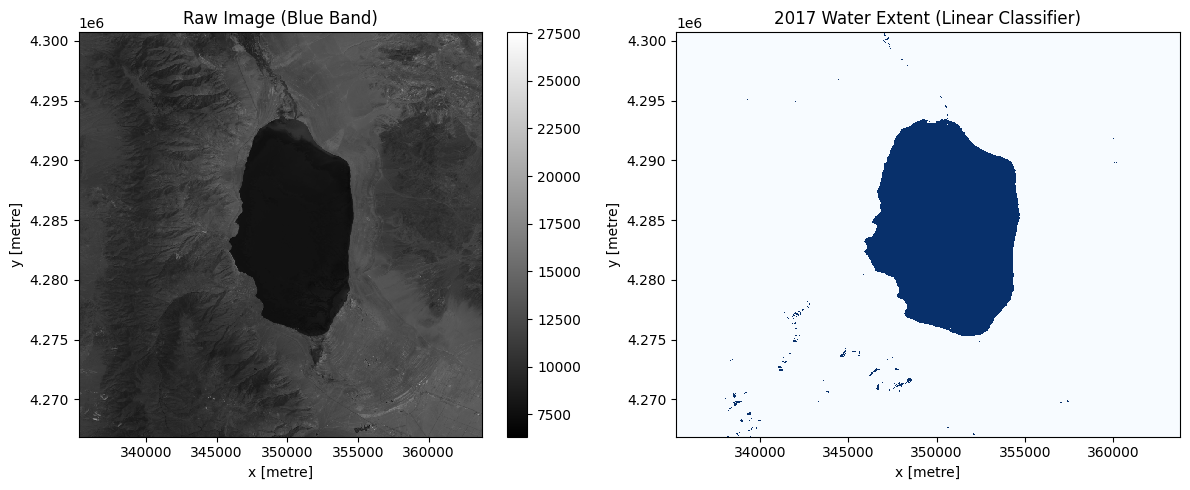

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot raw
da_2017.sel(band="blue").plot(ax=ax1, cmap="gray")
ax1.set_title("Raw Image (Blue Band)")

# Plot classification
water_classified.T.plot(ax=ax2, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax2.set_title("2017 Water Extent (Linear Classifier)")

plt.tight_layout()
plt.show()

### Band Separability Analysis

Before we calculate MNDWI, let's examine why it works so well for water detection. We'll look at the distribution of the green, blue, and SWIR1 bands for water vs non-water pixels based on our linear classifier labels.

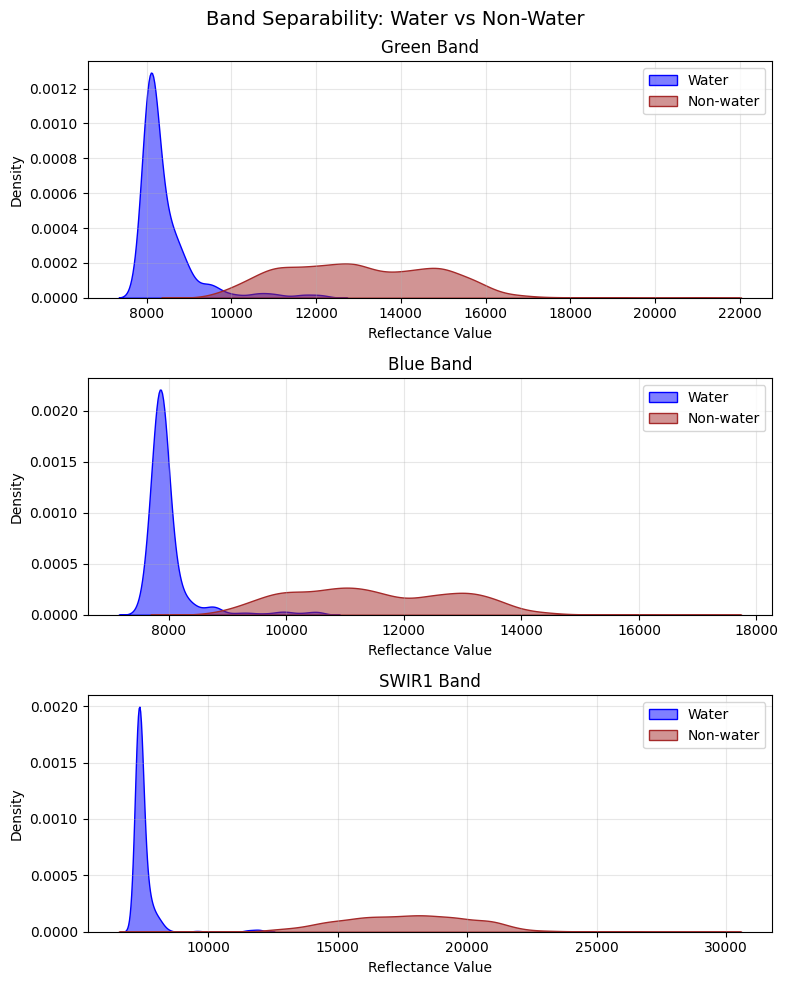

In [22]:
# Sample pixels for visualization (using all would be too many)
sample_size = 5000
sample_indices = np.random.choice(len(water_labels), size=sample_size, replace=False)

# Extract band values for sampled pixels
green_vals = flattened_t_xda_2017.sel(band="green").values[sample_indices]
blue_vals = flattened_t_xda_2017.sel(band="blue").values[sample_indices]
swir16_vals = flattened_t_xda_2017.sel(band="swir16").values[sample_indices]
labels_sample = water_labels[sample_indices]

# Create figure with vertically stacked density plots
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

bands_data = [
    (green_vals, "Green Band", axes[0]),
    (blue_vals, "Blue Band", axes[1]),
    (swir16_vals, "SWIR1 Band", axes[2]),
]

for band_vals, title, ax in bands_data:
    # Separate water and non-water
    water_mask = labels_sample == 1

    # Plot KDE density for each class
    sns.kdeplot(
        band_vals[water_mask], ax=ax, label="Water", color="blue", fill=True, alpha=0.5
    )
    sns.kdeplot(
        band_vals[~water_mask],
        ax=ax,
        label="Non-water",
        color="brown",
        fill=True,
        alpha=0.5,
    )

    ax.set_xlabel("Reflectance Value")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Band Separability: Water vs Non-Water", fontsize=14)
plt.tight_layout()
plt.show()

Notice how the green and blue bands show clear separation between water and non-water classes, with water having higher reflectance values in these visible bands. The SWIR1 band shows the opposite pattern - water absorbs SWIR radiation strongly, resulting in much lower reflectance values. This complementary behavior is exactly what makes MNDWI (Green - SWIR1) / (Green + SWIR1) such an effective water index!

## MNDWI and Otsu Thresholding

Now let's compare our supervised classifier to a simpler approach using [MNDWI](https://www.opendatacube.org/mndwi), a spectral index which combines the green and SWIR1 bands to enhance water features. We'll also apply Otsu's method to automatically determine an optimal threshold for water classification.

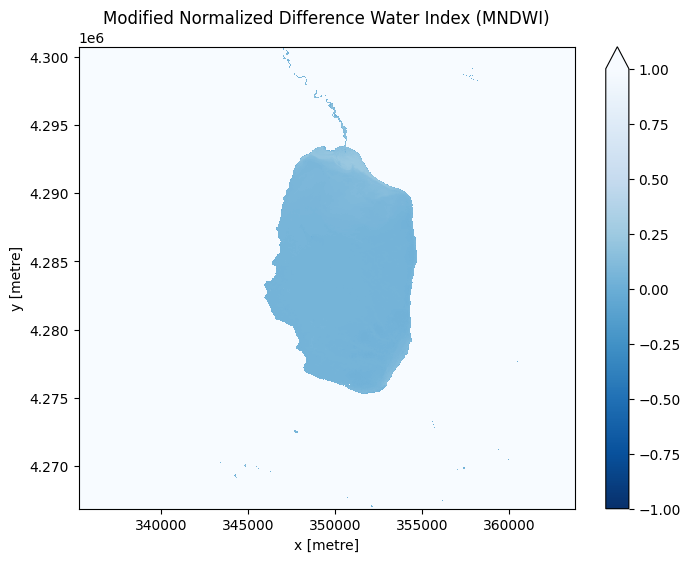

In [23]:
# Calculate MNDWI
mndwi = (ds_2017.green - ds_2017.swir16) / (ds_2017.green + ds_2017.swir16)

# Plot MNDWI
mndwi.plot(cmap="Blues_r", figsize=(8, 6), vmin=-1, vmax=1)
plt.title("Modified Normalized Difference Water Index (MNDWI)")
plt.show()

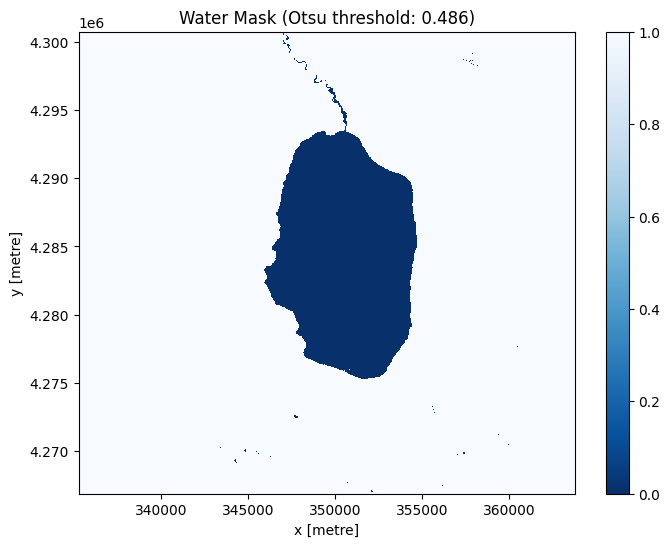

In [24]:
# Compute Otsu threshold
threshold = threshold_otsu(mndwi.values.flatten())

# Create binary mask
water_mask = mndwi > threshold

# Plot
water_mask.plot(cmap="Blues_r", figsize=(8, 6))
plt.title(f"Water Mask (Otsu threshold: {threshold:.3f})")
plt.show()

### MNDWI Distribution by Class

Let's examine how MNDWI values differ between water and non-water pixels according to our training labels:

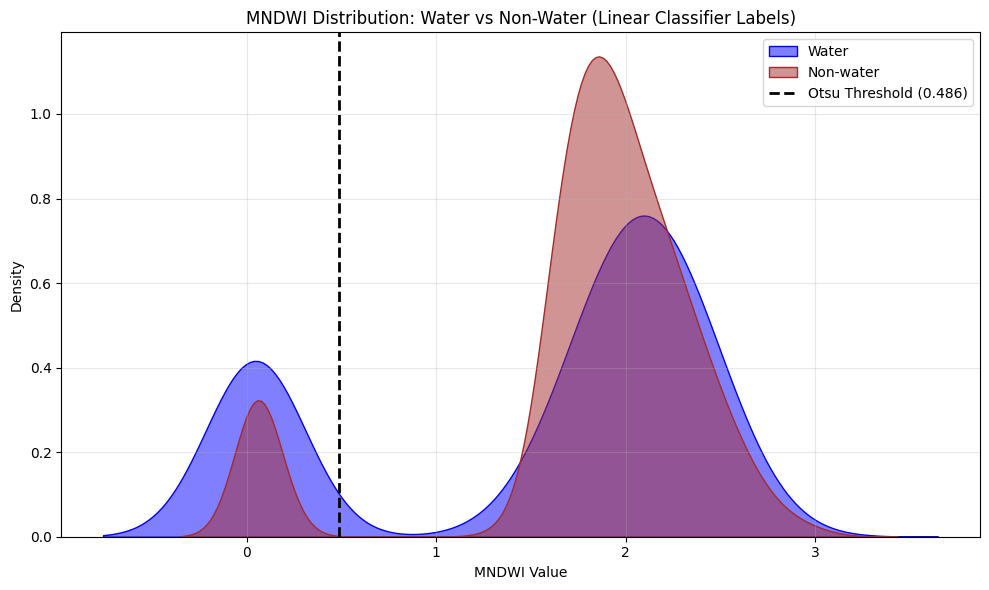

In [25]:
# Flatten MNDWI and sample
mndwi_flat = mndwi.values.flatten()
mndwi_sample = mndwi_flat[sample_indices]

# Create density plot split by training labels
fig, ax = plt.subplots(figsize=(10, 6))

water_mask_sample = labels_sample == 1

sns.kdeplot(
    mndwi_sample[water_mask_sample],
    ax=ax,
    label="Water",
    color="blue",
    fill=True,
    alpha=0.5,
)
sns.kdeplot(
    mndwi_sample[~water_mask_sample],
    ax=ax,
    label="Non-water",
    color="brown",
    fill=True,
    alpha=0.5,
)

# Add Otsu threshold line
ax.axvline(
    threshold,
    color="black",
    linestyle="--",
    linewidth=2,
    label=f"Otsu Threshold ({threshold:.3f})",
)

ax.set_xlabel("MNDWI Value")
ax.set_ylabel("Density")
ax.set_title("MNDWI Distribution: Water vs Non-Water (Linear Classifier Labels)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparison of Methods

Now let's compare all three water detection methods side by side:

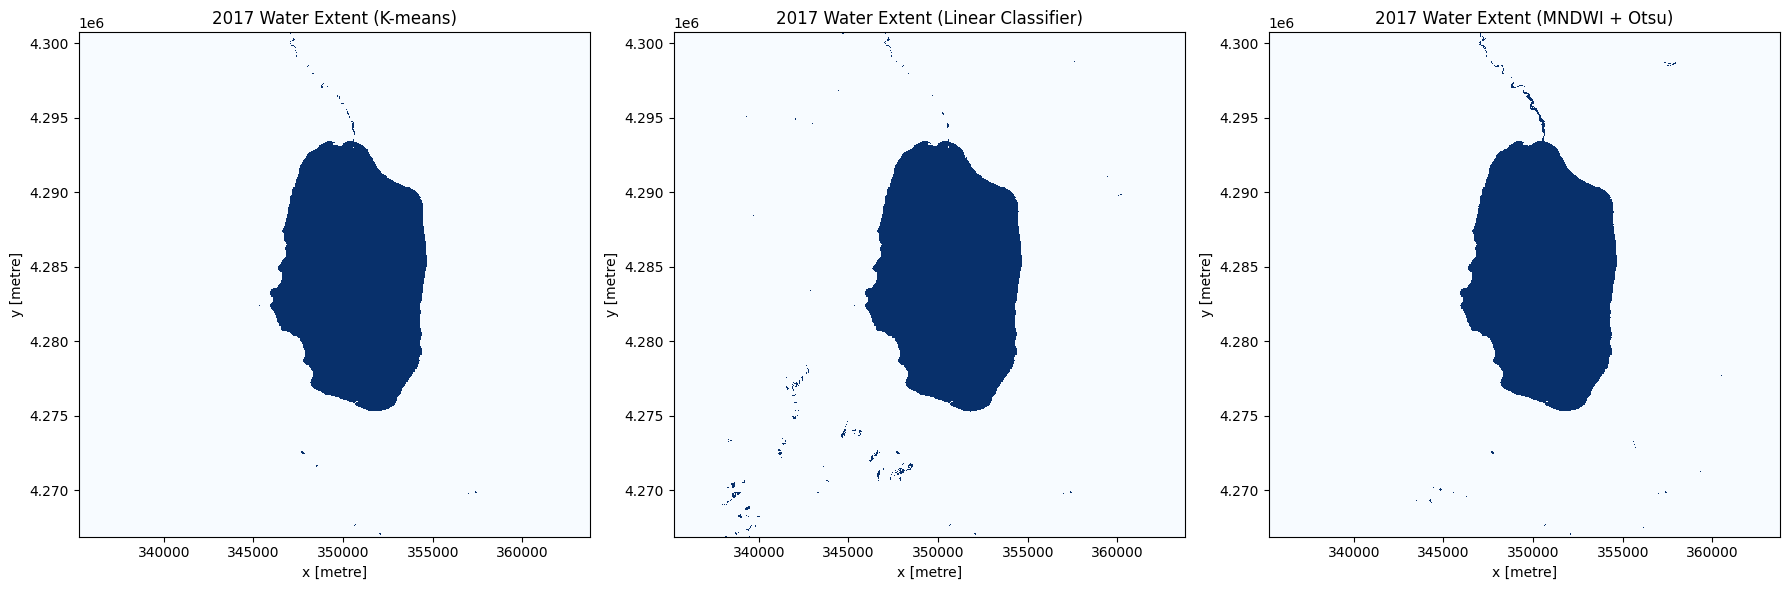

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# K-means water mask
water_2017.T.plot(ax=ax1, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax1.set_title("2017 Water Extent (K-means)")

# Linear classifier water mask
water_classified.T.plot(ax=ax2, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax2.set_title("2017 Water Extent (Linear Classifier)")

# Otsu water mask
water_mask.plot(ax=ax3, cmap="Blues_r", add_colorbar=False)
ax3.set_title("2017 Water Extent (MNDWI + Otsu)")

plt.tight_layout()
plt.show()

## Final Comparison: All Methods with Original Image

Let's create a 2x2 comparison showing the original image and all three water detection methods:

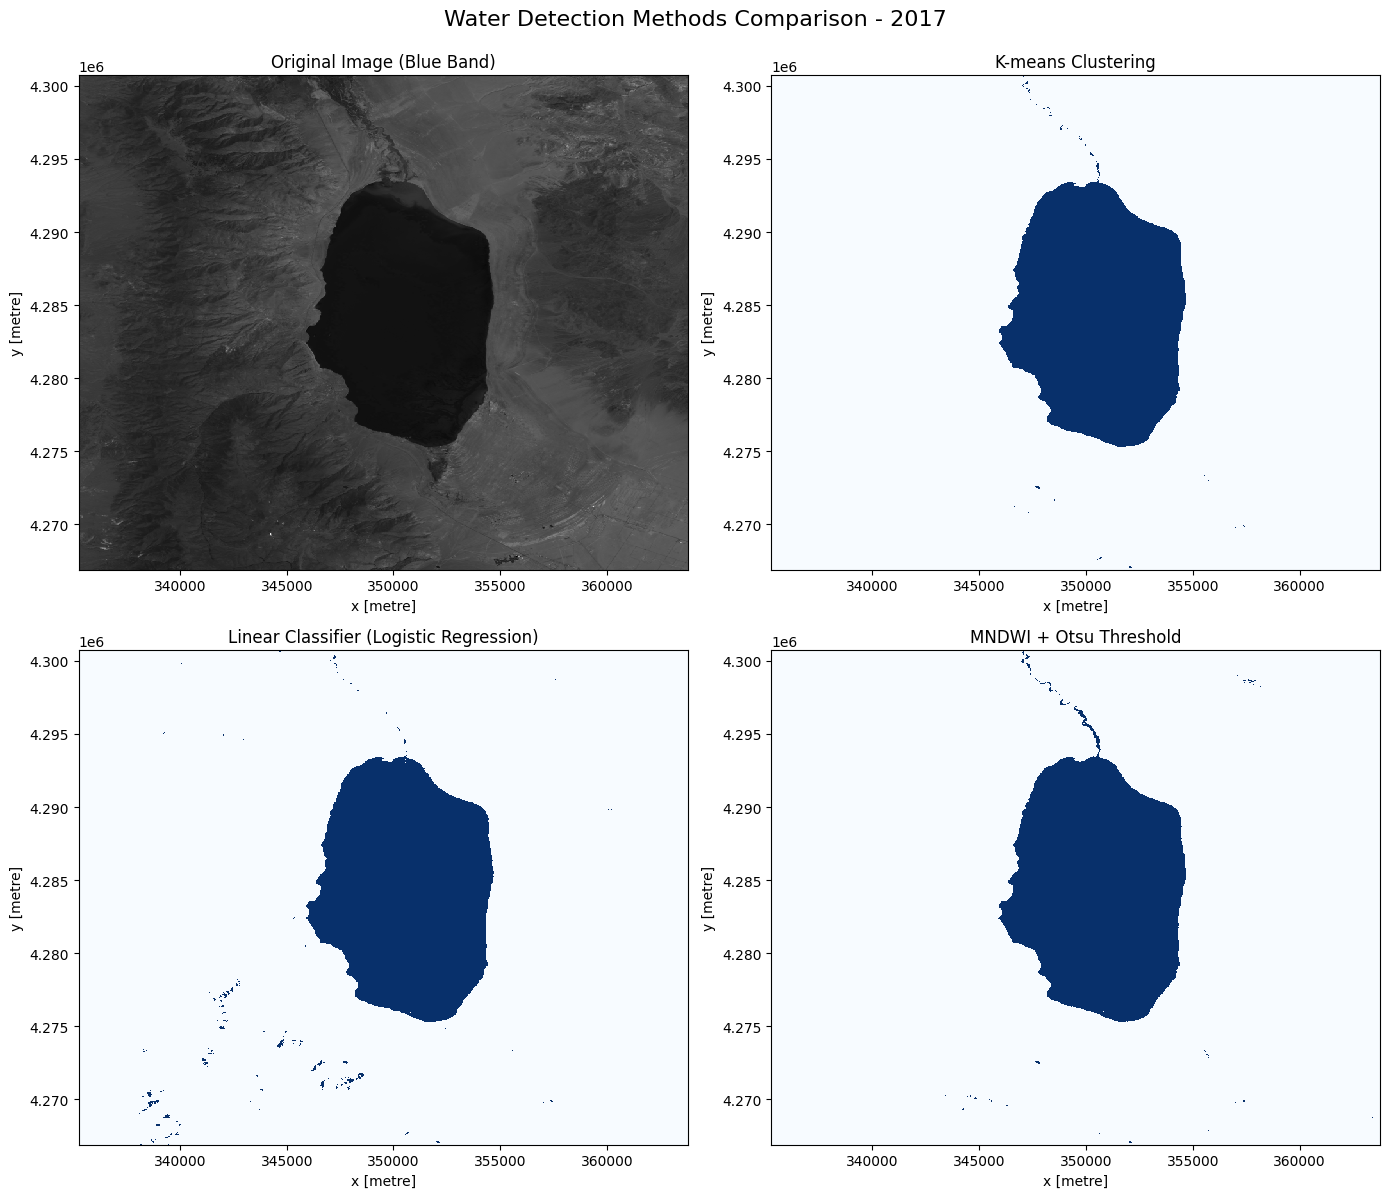

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original image (red band)
da_2017.sel(band="blue").plot(ax=axes[0, 0], cmap="gray", add_colorbar=False)
axes[0, 0].set_title("Original Image (Blue Band)")

# K-means
water_2017.T.plot(ax=axes[0, 1], cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
axes[0, 1].set_title("K-means Clustering")

# Linear classifier
water_classified.T.plot(ax=axes[1, 0], cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
axes[1, 0].set_title("Linear Classifier (Logistic Regression)")

# MNDWI + Otsu
water_mask.plot(ax=axes[1, 1], cmap="Blues_r", add_colorbar=False)
axes[1, 1].set_title("MNDWI + Otsu Threshold")

plt.suptitle("Water Detection Methods Comparison - 2017", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()